In [16]:
! pip install numpy pandas PyQt6 gymnasium "gymnasium[other]" "gymnasium[classic-control]"

#### Imports

In [17]:
from typing import Optional
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from IPython.display import display, clear_output

N_EPISODES = 1000

#TODO: 
# scale heat map 
# reward function.
# Vend world rigtig så koordinater stiger op af y-aksen.
# a better or complete understand of reward system in gymAI and how to give each state a reward

#### World class

In [ ]:
class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 10):
        # The size of the square grid
        self.size = size
        self.trajectory = []
        self.world = np.zeros((size, size))
        self.poi_states = [[0 for _ in range(size)] for _ in range(size)]


        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
        self._visited_states = np.zeros((3, 3))
        self._actions_taken = np.zeros(8)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
            "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "visited_states": gym.spaces.Box(-1, 1, shape=(3, 3), dtype=int),
            "actions_taken": gym.spaces.Box(0, 7, shape=(8,), dtype=int),
            }
        )

        # We have 8 actions, corresponding to "right", "up", "left", "down" and diagonal
        self.action_space = gym.spaces.Discrete(8)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([1, 1]),  # up-right
            5: np.array([-1, 1]),  # up-left
            6: np.array([-1, -1]),  # down-left
            7: np.array([1, -1]),  # down-right
        }
   
    def random_env(self):
        self.world = np.random.randint(1, 11, size=(self.size, self.size))
    
    def world_from_matrix(self, matrix):
        self.world = matrix

    def setReward(self, x, y , reward):
        self.world[x][y] = reward
    
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location, "visited_states": self._visited_states, "actions_taken":self._actions_taken}

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def getReward(self):
        return self.world[self._agent_location[0], self._agent_location[1]]

    def state_update(self):



    def step(self, action):
        # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid bounds
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        # An environment is completed if and only if the agent has searched all states
        terminated = False
        truncated = False
        reward = self.getReward()
        observation = self._get_obs()
        info = self._get_info()

        

        return observation, reward, terminated, truncated, info

#### Agent Class
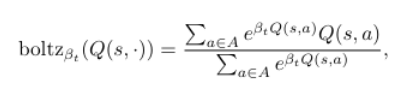

In [ ]:
class SAR_agent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))   # Q-values for each state-action pair

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.beta = 0.85
        self.trajectory = []

        self.training_error = []

    def reset_trajectory(self):
        self.trajectory = []

    def get_action(self, obs: dict) -> int:
        """
        Selects an action using the Boltzmann softmax function.
        Actions with higher Q-values are more likely to be chosen.
        """
        agent_state = tuple(obs['agent'])  # Convert agent's position to a hashable tuple

        # Ensure the state exists in the Q-table
        if agent_state not in self.q_values:
            self.q_values[agent_state] = np.zeros(self.env.action_space.n)

        q_values = self.q_values[agent_state]

        # Compute exponentiated Q-values with numerical stability
        exp_q = np.exp(self.beta * q_values - np.max(self.beta * q_values))

        # Compute Boltzmann probabilities (for action selection)
        probs = exp_q / np.sum(exp_q)  

        # Sample action based on the probability distribution
        return np.random.choice(len(q_values), p=probs)




    def update(
        self,
        obs: dict,  
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict,  
        visited_states,
    ):
        # Extract agent's position and convert to tuple (ensuring it's hashable)
        agent_state = tuple(obs['agent'])  
        next_agent_state = tuple(next_obs['agent'])  

        # direction = self.env.get_direction[action]


        x, y = obs['agent']
        visited_states_near = obs['visited_states']
        actions_taken = obs['actions_taken']

        actions_taken = action


        # Load visited_states_near with visited states
        # visited_states_near[action] = 1

        # Ensure both states exist in Q-table
        if agent_state not in self.q_values:
            self.q_values[agent_state] = np.zeros(self.env.action_space.n)
        if next_agent_state not in self.q_values:
            self.q_values[next_agent_state] = np.zeros(self.env.action_space.n)

        # Compute future Q-value
        if not terminated:
            exp_q_next = np.exp(self.beta * self.q_values[next_agent_state] - np.max(self.beta * self.q_values[next_agent_state]))
            boltz_q = np.sum(exp_q_next * self.q_values[next_agent_state]) / np.sum(exp_q_next)  # Weighted sum
            future_q_value = boltz_q
        else:
            future_q_value = 0  # Terminal state



        # Define a smaller penalty factor
        visit_penalty = 1.0 + visited_states[y][x] * 100  # Gradual increase
        if(visited_states[y][x] == 0):
            visit_penalty *= -1

        # Compute temporal difference (TD) error with softer penalty
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[agent_state][action] - visit_penalty  # Penalize visited states more, but not too harshly
        )


        # Update Q-value
        self.q_values[agent_state][action] += self.lr * temporal_difference

        # Track training error
        self.training_error.append(temporal_difference)

    def plot_trajectory(self, env_size, time_step):
        """Animate the agent's trajectory on a grid."""
        plt.figure()  # Create a figure
        for i, state in enumerate(self.trajectory):
            clear_output(wait=True)  # Clears the previous plot
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("Agent's Trajectory Simulation")
            plt.grid(True)
            
            # Plot all previous points in blue
            past_x, past_y = zip(*self.trajectory[: i + 1])  # Get all visited points
            plt.plot(past_x, past_y, "bo-", label="Past Path")  # Blue path
            
            # Plot current point in red
            plt.plot(state[0], state[1], "ro", markersize=10, label="Current Position")
            
            plt.legend()
            plt.xlim(-1, env_size + 1)  # Set limits to prevent resizing
            plt.ylim(-1, env_size + 1)
            plt.pause(time_step)  # Pause for animation
        
        plt.show()  # Keep the final plot displayed
        



#### Swarm Class

In [20]:
class swarm:
    def __init__(self, env, agents, num_agents, env_size, n_episodes):
        self.env = env
        self.agents = agents
        self.num_agents = num_agents
        self.visited_states = [[0 for _ in range(env_size)] for _ in range(env_size)]
        self.cum_reward = []    # :TODO overvej nyt navn
        self.env_size = env_size
        self.episode_cum_reward = [0 for _ in range(N_EPISODES)]
        self.n_episodes = n_episodes

    #writes to visited states
    def state_visited(self, obs):
        x, y = obs['agent']
        self.visited_states[y][x] += 1  # mark as visited

    #reads from visited states
    def state_has_been_visited(self, obs):
        x, y = obs['agent']
        return self.visited_states[y][x] == 1

    #resets visited states list
    def reset_visited(self):
        self.visited_states = [[0 for _ in range(self.env_size)] for _ in range(self.env_size)]

    
    def reset_trajectory(self):
        for agent in self.agents:
            agent.reset_trajectory()
    
    def add_trajectory(self, agent, obs):
        agent.trajectory.append(obs['agent'])

    def train_swarm(self, max_steps):
        for episode in range(self.n_episodes):
            # Reset the environment for the start of the episode
            obs, info = self.env.reset()
            self.reset_trajectory()
            self.reset_visited()
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:
                for agent in self.agents:
                    # Select an action
                    action = agent.get_action(obs)

                    # Take a step in the environment
                    next_obs, reward, terminated, truncated, info = self.env.step(action)

                    #add the state to visited list, only if it has not already been visited. make the reward for the action 10 lower, if it was already visited
                    if self.state_has_been_visited(obs):
                        reward += 0
                    else:
                        self.state_visited(obs)

                
                    agent.update(obs, action, reward, terminated, next_obs, self.visited_states)
                    self.add_trajectory(agent, obs)
                    self.episode_cum_reward[episode] += reward

                    if(steps >= max_steps):
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1

            self.episode_cum_reward.append(self.cum_reward)

        # Print cum reward for each episode
        for episode in range(self.n_episodes):
            print(self.episode_cum_reward[episode])


    def plot_reward_episode(self):
        """"Plots reward per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.episode_cum_reward[:self.n_episodes]  # Ensure the length matches n_episodes

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward per Episode')
        plt.show()

        
        



#### Heatmap import

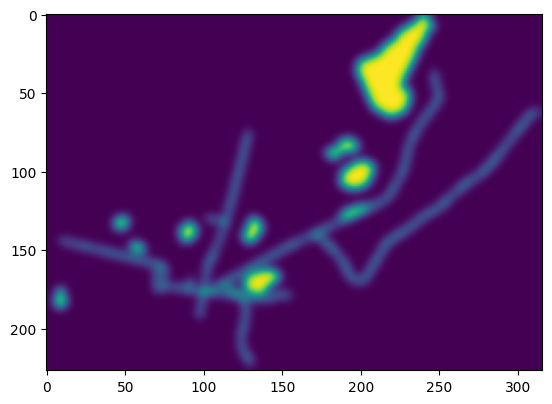

In [21]:
def matrix_from_heatmap():
    with open("../Kaspers_chad_pdfer_mm/heatmap/data/heatmap.pkl", "rb") as f:
        heatmap = pickle.load(f)
    plt.imshow(heatmap, cmap='viridis')    # :TODO skalere map så det passer i den gridworld man vælger.
    return heatmap

heatmap = matrix_from_heatmap()


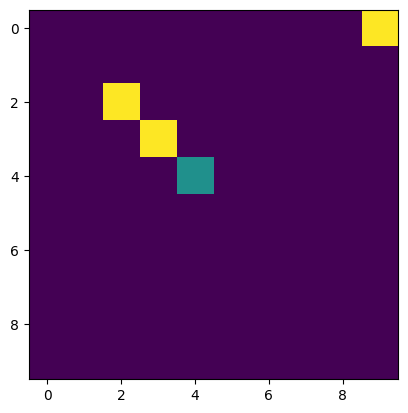

In [22]:
# hyperparameters
learning_rate = 0.01
size = 10

env = GridWorldEnv(size=size)
# env.world_from_matrix(heatmap)
env.setReward(0, 9, 10)
env.setReward(2, 2, 10)
env.setReward(3, 3, 10)
env.setReward(4, 4, 5)
env.setReward(4, 4, 5)

# Display world

plt.imshow(env.world, cmap='viridis')

env = gym.wrappers.TimeLimit(env, max_episode_steps=1000)

agent = SAR_agent(
    env=env,
    learning_rate=learning_rate,
)

agents = []
agents.append(agent)

In [23]:
swarm = swarm(env, agents, 15, 10, N_EPISODES)

swarm.train_swarm(75)
swarm.plot_reward_episode()

AttributeError: 'TimeLimit' object has no attribute 'get_direction'

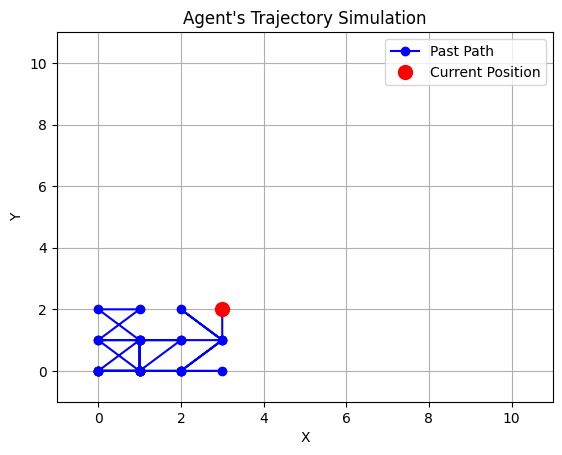

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Simulated episode rewards, lengths, and training errors
return_queue = [np.random.randint(-10, 10) for _ in range(1000)]  # Example rewards
length_queue = [np.random.randint(1, 100) for _ in range(1000)]   # Example episode lengths
training_error = [np.random.uniform(-1, 1) for _ in range(1000)]  # Example training errors

# Smooth over a 500 episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))



axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episodes")  
axs[0].set_ylabel("Reward")  

# Plot the episode rewards as they are collected
axs[0].plot(range(len(swarm.episode_cum_reward)), swarm.episode_cum_reward, label="Episode Reward")

axs[0].legend()








plt.tight_layout()
plt.show()

agents[0].plot_trajectory(size, 0.05)



#### Record Agent
TODO:

In [ ]:
# import gymnasium as gym
# from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# num_eval_episodes = 4

# env = GridWorldEnv(size=10)
# env = RecordVideo(env, video_folder="cartpole-agent", name_prefix="eval",
#                   episode_trigger=lambda x: True)
# env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

# for episode_num in range(num_eval_episodes):
#     obs, info = env.reset()

#     episode_over = False
#     while not episode_over:
#         action = env.action_space.sample()  # replace with actual agent
#         obs, reward, terminated, truncated, info = env.step(action)

#         episode_over = terminated or truncated
# env.close()

# print(f'Episode time taken: {env.time_queue}')
# print(f'Episode total rewards: {env.return_queue}')
# print(f'Episode lengths: {env.length_queue}')
